## focus on soc measurements

In [1]:
import pandas as pd
df = pd.read_parquet('./material/soil_organized.pq')
print(df.shape)

(409369, 644)


In [2]:
drop_col = ['bulk.density.tot_qa', 'bulk.density.tot',
'bulk.density.fe_qa', 'bulk.density.fe', 'coarse.mass_qa',
'coarse.mass', 'coarse.vol_qa', 'coarse.vol', 'ocd', 'ph.h2o_qa',
'ph.h2o', 'sand_qa', 'sand', 'silt_qa', 'silt', 'clay_qa', 'clay',
'total.n_qa', 'total.n', 'carbonates_qa', 'carbonates', 'ph.cacl2_qa',
'ph.cacl2', 'extractable.p_qa', 'extractable.p', 'extractable.k_qa',
'extractable.k', 'ec_qa', 'ec', 'cec_qa', 'cec','tile_id', 'texture1', 
'texture2', 'texture1_qa', 'texture2_qa']
df = df.drop(columns=drop_col)
print(df.shape)

(409369, 608)


In [3]:
df = df.loc[df['soc_qa']>2]
print(df.shape)

(124625, 608)


In [4]:
df = df.dropna(subset=['soc'],how='any')
print(df.shape)

(121394, 608)


In [5]:
df = df.loc[df['ref']=='LUCAS']
print(df.shape)

df = df.loc[df['hzn_dep']==10]
print(df.shape)

(62578, 608)
(62200, 608)


## organize lucas soc time series

In [6]:
dfs = df
lid = dfs.groupby('id').filter(lambda x: len(x) == 3)['id'].unique().tolist() # only focus on 3-pnt series

In [7]:
name_map = {'ndvi_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231127':'ndvi_p50',
            'ndwi.gao_glad.landsat.ard2.seasconv.m.yearly_p50_30m_s_YYYY0101_YYYY1231_eu_epsg.3035_v20231218':'ndwi_p50',
            'ndvi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_m_30m_s_20000101_20221231_eu_epsg.3035_v20231218':'ndvi_slope',
            'ndwi_glad.landsat.ard2.seasconv.yearly.m.theilslopes_m_30m_s_20000101_20221231_eu_epsg.3035_v20231218':'ndwi_slope'}

dfs = dfs.rename(columns = name_map)
            
for col in ['ndvi_p50','ndwi_p50']:
    dfs[col] = (dfs[col]-125)/125
    

In [8]:
tcol = ['lat', 'lon', 'time', 'soc', 'lc_survey', 'ndvi_p50', 'ndwi_p50'] # time series cols
scol = ['id', 'ref', 'nuts0', 'hzn_dep', 'ndvi_slope','ndwi_slope'] # static cols
mcol = ['lat', 'lon', 'ndvi_p50','ndwi_p50'] # cols that needs to take the average of the time series


In [9]:
from skmap.misc import TimeTracker, ttprint

ttprint('start organizing')
tsdf = pd.DataFrame(columns=scol + [i+'_mean' for i in mcol] + [i+'_series' for i in tcol])
for iid in lid:
    temp = dfs.loc[dfs['id'] == iid].sort_values(by=['time'])  
    
    # Extract static values (first row of static columns)
    static_vals = temp.iloc[0][scol].tolist()
    
    # Compute mean values for columns requiring averaging
    mean_vals = temp[mcol].mean().tolist()
    
    # Extract time series values as lists
    ts_vals = [temp[itcol].tolist() for itcol in tcol]
    
    # Concatenate all extracted values
    tsdf.loc[len(tsdf)] = static_vals + mean_vals + ts_vals
    
ttprint('finish organizing')

[14:22:14] start organizing
[14:24:05] finish organizing


In [10]:
tsdf.to_csv('./material/soc_time.series_lucas.csv',index=False)

## analyze time series


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import geopy.distance

dist = []

trend_class = []
fluctuate = []
lc_change = []
lcl1 = []
d_threshold = 0.5  # Define a threshold for stability

for index, row in tsdf.iterrows():
    soc = row['soc_series']
    time = row['time_series']
    
    colat = row['lat_series']
    colon = row['lon_series']
    
    dist.append([geopy.distance.geodesic((colon[0], colat[0]),(colon[1], colat[1])).m,
                 geopy.distance.geodesic((colon[1], colat[1]),(colon[2], colat[2])).m])
    
    fluctuate.append([abs(soc[1]-soc[0]),abs(soc[2]-soc[1])])
    
    lc_level1 = [ii[0] for ii in row['lc_survey_series']]
    lcl1.append(lc_level1)
    if len(set(lc_level1))==1:
        lc_change.append(0)
    else:
        lc_change.append(1)

    # Check for increasing trend
    if (soc[2] > soc[1]) and (soc[1] > soc[0]):
        trend_class.append('increasing')

    # Check for decreasing trend
    elif (soc[2] < soc[1]) and (soc[1] < soc[0]):
        trend_class.append('decreasing')

    # Check for stability vs. noise
    else:
        d1 = abs(soc[1] - soc[0]) / (time[1] - time[0])
        d2 = abs(soc[2] - soc[1]) / (time[2] - time[1])
        
        if (d1 < d_threshold) and (d2 < d_threshold):
            trend_class.append('stable')
        else:
            trend_class.append('noisy')

# Add the classification back to the DataFrame
tsdf['trend_class'] = trend_class
tsdf['fluctuation'] = fluctuate
tsdf['lc_change'] = lc_change
tsdf['lc_level1'] = lcl1
tsdf['distance'] = dist

In [2]:
import pandas as pd
tsdf = pd.read_csv('./material/soc_time.series_lucas.csv')
tsdf['time_series'].unique()

array(['[2009, 2015, 2018]', '[2012, 2015, 2018]'], dtype=object)

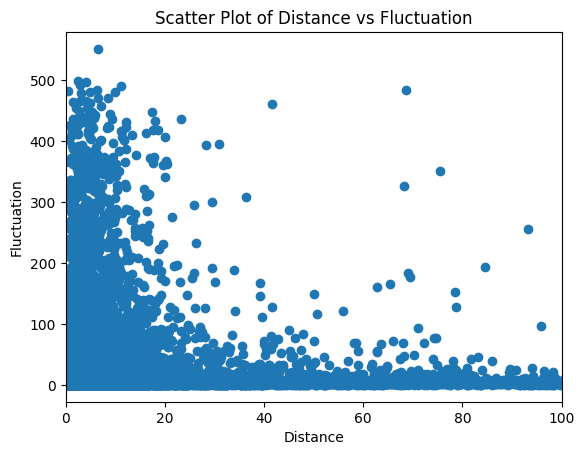

In [19]:


# Flatten lists using list comprehension
dist_flat = [item for sublist in dist for item in sublist]
fluctuate_flat = [item for sublist in fluctuate for item in sublist]

# Scatter plot
plt.scatter(dist_flat, fluctuate_flat)
plt.xlim([0,100])
plt.xlabel("Distance")
plt.ylabel("Fluctuation")
plt.title("Scatter Plot of Distance vs Fluctuation")
plt.show()


In [ ]:
for ii in tsdf['trend_class'].unique():
    print(ii, len(tsdf.loc[tsdf['trend_class']==ii]),round(tsdf.loc[tsdf['trend_class']==ii,'fluctuation'].mean(),3))
    

In [ ]:
tsdf

In [ ]:
import matplotlib.pyplot as plt

# Extract unique trend classes
trend_classes = tsdf['trend_class'].unique()

# Prepare data for plotting
counts = [len(tsdf.loc[tsdf['trend_class'] == ii]) for ii in trend_classes]
mean_fluctuations = [tsdf.loc[tsdf['trend_class'] == ii, 'fluctuation'].mean() for ii in trend_classes]
std_fluctuations = [tsdf.loc[tsdf['trend_class'] == ii, 'fluctuation'].std() for ii in trend_classes]

# Create bar plot with error bars
plt.figure(figsize=(10, 6))
plt.bar(trend_classes, mean_fluctuations, yerr=std_fluctuations, capsize=5, alpha=0.7)
plt.xlabel('Trend Class')
plt.ylabel('Mean Fluctuation')
plt.title('Mean Fluctuation by Trend Class with Variation')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [ ]:
ts = tsdf.loc[tsdf['fluctuation']<4.5]

In [ ]:
ts['fluctuation'].hist(bins=40)

In [ ]:
tsdf.loc[tsdf['lc_change']==0,'fluctuation'].hist(bins=40)

In [ ]:
sampled_df

In [ ]:
sampled_df = tsdf.groupby('trend_class').apply(lambda x: x.sample(n=1, replace=True) if len(x) >= 4 else x).reset_index(drop=True)

for index, row in sampled_df.iterrows():
    soc = row['soc_series']
    time = row['time_series']
    
    # Plot the time series
    plt.figure(figsize=(6,3))
    plt.plot(time, soc, marker='o', linestyle='-')
    plt.title(f"Point id: {row['id']}, {row['trend_class']}")
    plt.xlabel("Year")
    plt.ylabel("SOC (g/kg)")
    plt.show()


In [ ]:
for index, row in tsdf.iterrows():
    soc = row['soc_series']
    time = row['time_series']
    fluctuate.append(np.max(soc)-np.min(soc))
    
    # # Plot the time series
    # plt.plot(time, soc, marker='o', linestyle='-')
    # plt.title(f"Time Series {index}")
    # plt.xlabel("Year")
    # plt.ylabel("SOC")
    # plt.show()